<a href="https://colab.research.google.com/github/Abdallah189/Abdallah/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Tutorial about Generative Adversarial Networks (GANs)

##Generate handwritten digits by GAN

###Prerequisites

You need to install [Pytorch](https://pytorch.org/), [NumPy](https://numpy.org/), [Matplotlib](https://matplotlib.org/) to run this notebook on your machine and finish tasks.

Or you can run this notebook in [Google Colab](https://colab.research.google.com/) which allows you to execute Python in your browser.

If you are not familar with [Pytorch](https://pytorch.org/), [NumPy](https://numpy.org/), [Matplotlib](https://matplotlib.org/), I recommend you to finish the tutorials on the coresponding sites (or just skip through them), which will help you have a better understanding about those basic packages in the filed of AI.

##Introduction

According to Yann LeCun, “adversarial training is the coolest thing since sliced bread.” Sliced bread certainly never created this much excitement within the deep learning community. Generative adversarial networks—or GANs, for short—have dramatically sharpened the possibility of AI-generated content, and have drawn active research efforts since they were first described by [Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661).

GANs are neural networks that learn to create synthetic data similar to some known input data. For instance, researchers have generated convincing images from [photographs of everything from bedrooms to album covers](https://github.com/Newmu/dcgan_code), and they display a remarkable ability to reflect higher-order semantic logic.

Those examples are fairly complex, but it's easy to build a GAN that generates very simple images. In this tutorial, we'll build a GAN that analyzes lots of images of handwritten digits and gradually learns to generate new images from scratch—*essentially, we'll be teaching a neural network how to write.*

![Alt Text](https://tensorflow.org/images/gan/dcgan.gif)

Sample images from the generative adversarial network that we'll build in this tutorial. During training, it gradually refines its ability to generate digits.




##GAN architecture

Generative adversarial networks consist of two models: a generative model and a discriminative model.

![text](https://camo.githubusercontent.com/46f358c467393af580c0c1bae5278ab9f9fe97a3e5a8f3a0da9c8ef42461efdd/687474703a2f2f7777772e74696d7a68616e6779757875616e2e636f6d2f7374617469632f696d616765732f70726f6a6563745f444347414e2f7374727563747572652e706e67)

The discriminator model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The generator model takes random input values and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

##Getting start

We’re going to create a GAN that will generate handwritten digits that can fool even the best classifiers (and humans too, of course). We'll use [Pytorch](https://pytorch.org/), a open-sourced deep learning library that makes it easy to train neural networks.

This tutorial expects that you're already at least a little bit familiar with Pytorch. If you're not, we recommend reading [Pytorch tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before proceeding.



```
# Ce texte est au format code
```

MNIST Data Loading
-------------------

We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

Let's start by importing Pytorch along with a couple of other helpful libraries. We'll also import our MNIST images using a Pytorch convenience function called *torchvision.datasets.MNIST*.

In [73]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np

import matplotlib.pyplot as plt

In [74]:
# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784  # 28*28
num_epochs = 200
batch_size = 100

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)


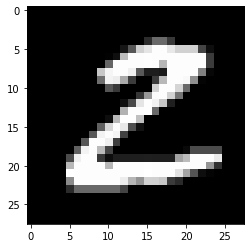

In [75]:
# show MNIST image example
random_sample_num = np.random.choice(1000)
plt.imshow(mnist[random_sample_num][0][0,:,:].numpy(),'gray')

If you run the cell above again, you'll see a different image from the MNIST training set.

##Discriminator network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.

In [76]:
# Implement Discriminator
D=  nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
   )

Generator network
-----------------------




You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2- or 3-dimensional matrix of pixel values into a single probability. A generator, however, takes a d-dimensional vector of noise and upsamples it to become a 28 x 28 image. 

In [77]:
# Implement Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

Device configuration

In [78]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Device setting
D = D.to(device)
G = G.to(device)    


num_params_gen = sum(p.numel() for p in G.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in D.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 283920 and discriminator: 267009


##Training GAN

One of the trickiest parts about building and tuning GANs is that they have two loss functions: one that encourages the generator to create better images, and the other that encourages the discriminator to distinguish generated images from real images.

We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# record average loss for each epoch
gen_loss_avg = []
disc_loss_avg = []

# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        gen_loss_avg[-1] += g_loss.item()
        disc_loss_avg[-1] += d_loss.item()
        num_batches += 1
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
            
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches
        

Epoch [0/200], Step [200/600], d_loss: 0.0518, g_loss: 4.0776, D(x): 0.99, D(G(z)): 0.04
Epoch [0/200], Step [400/600], d_loss: 0.1080, g_loss: 4.6637, D(x): 0.97, D(G(z)): 0.07
Epoch [0/200], Step [600/600], d_loss: 0.1338, g_loss: 3.8237, D(x): 0.97, D(G(z)): 0.09
Epoch [1/200], Step [200/600], d_loss: 0.3627, g_loss: 4.5869, D(x): 0.88, D(G(z)): 0.10
Epoch [1/200], Step [400/600], d_loss: 0.3054, g_loss: 5.1288, D(x): 0.94, D(G(z)): 0.13
Epoch [1/200], Step [600/600], d_loss: 0.9812, g_loss: 2.9190, D(x): 0.81, D(G(z)): 0.38
Epoch [2/200], Step [200/600], d_loss: 0.6542, g_loss: 3.8904, D(x): 0.85, D(G(z)): 0.25
Epoch [2/200], Step [400/600], d_loss: 0.1333, g_loss: 4.2164, D(x): 0.96, D(G(z)): 0.07
Epoch [2/200], Step [600/600], d_loss: 1.0271, g_loss: 1.8128, D(x): 0.66, D(G(z)): 0.21
Epoch [3/200], Step [200/600], d_loss: 0.4533, g_loss: 3.3250, D(x): 0.87, D(G(z)): 0.13
Epoch [3/200], Step [400/600], d_loss: 1.0974, g_loss: 2.9446, D(x): 0.65, D(G(z)): 0.17
Epoch [3/200], Step [

In [82]:
# Save the model checkpoints 
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

##Plot Training Curves

We can see the loss during the whole training session.

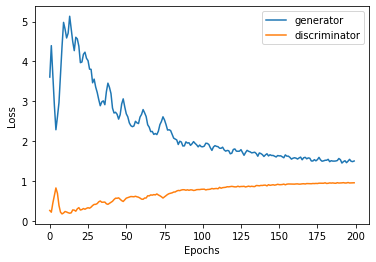

In [83]:
plt.ion()

fig = plt.figure()
plt.plot(gen_loss_avg, label='generator')
plt.plot(disc_loss_avg, label='discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



```
# `Ce texte est au format code`
```

##Training difficulties

GANs are notoriously difficult to train. Without the right hyperparameters, network architecture, and training procedure, the discriminator can overpower the generator, or vice-versa.

In one common failure mode, the discriminator overpowers the generator, classifying generated images as fake with absolute certainty. When the discriminator responds with absolute certainty, it leaves no gradient for the generator to descend. This is partly why we built our discriminator to produce unscaled output rather than passing its output through a sigmoid function that would push its evaluation toward either 0 or 1.

In another common failure mode known as mode collapse, the generator discovers and exploits some weakness in the discriminator. You can recognize mode collapse in your GAN if it generates many very similar images regardless of variation in the generator input z. Mode collapse can sometimes be corrected by "strengthening" the discriminator in some way—for instance, by adjusting its training rate or by reconfiguring its layers.

Researchers have identified a handful of [GAN hacks](https://github.com/soumith/ganhacks)" that can be helpful in building stable GANs.

##Test our GAN generator

Generate some images by our trained generator

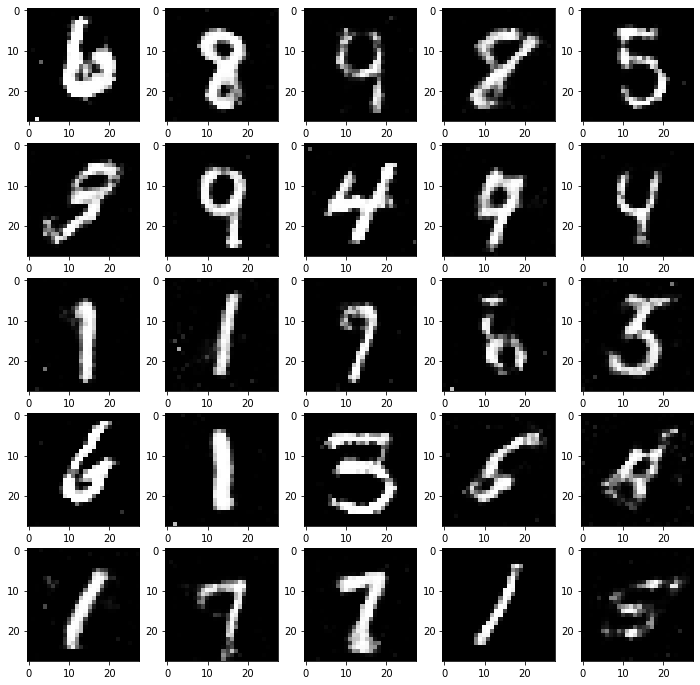

In [84]:

# Generate fake images
fake_images = G(torch.randn(25, latent_size, device=device))
fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28).cpu().detach().numpy()

# Plot fake images
_, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(fake_images, axs):
    ax.imshow(img[0,:,:],cmap='gray')
plt.show()